In [31]:
import numpy as np
import math as mp
import pandas as pd

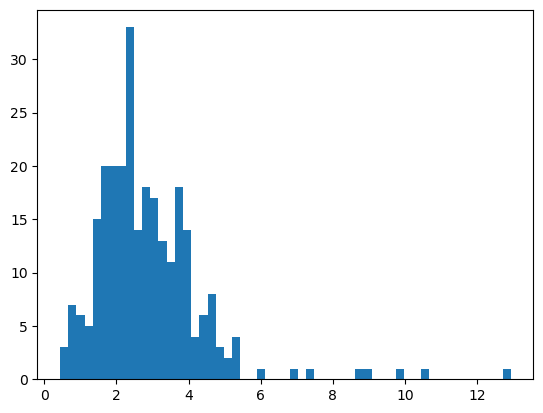

In [32]:
data=pd.read_csv('APP_data_usa_goods.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data_tau=(data['invtCogsRatio']* 36.5/(30*0.1))
import matplotlib.pyplot as plt
plt.hist(data_tau,bins = 55)
plt.show()

In [33]:
sigma = 2
beta = 1 /( 1.0 +0.01)
beta1 =1/( (1.0 +0.01* np.exp(30/(36.5*0.9)))) 
beta_hh =  beta
W = 1

In [34]:
tau_diff = np.zeros(( 1000,1))
i = 0
for c in np.linspace(0, 0.99, 1000): 
    N = -(data_tau) - 1/np.log(beta*c) 
    tau1= -1/np.log(beta*c) - N
    tau1[tau1<0] = 0     
    tau2= -1/np.log(beta1*c) - N
    tau2[tau2<0] = 0    
    tau_diff[i] = np.mean(np.abs(tau1-tau2))
    i = i+1

/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_12310/1678760125.py:4: RuntimeWarning: divide by zero encountered in log
  N = -(data_tau) - 1/np.log(beta*c)
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_12310/1678760125.py:5: RuntimeWarning: divide by zero encountered in log
  tau1= -1/np.log(beta*c) - N
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_12310/1678760125.py:7: RuntimeWarning: divide by zero encountered in log
  tau2= -1/np.log(beta1*c) - N


In [35]:
min_val = np.min(np.abs(tau_diff-1))
argmins = np.where(np.abs(tau_diff-1) == min_val)[0]

In [36]:
c_list = np.linspace(0, 0.99, 1000)
ccccc=c_list[argmins]

In [37]:
c

0.99

In [38]:
N=-data_tau - 1/np.log(beta_hh*ccccc) 
tau= -1/np.log(beta_hh*ccccc) - N
tau[tau<0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil=  (beta_hh*ccccc)**tau_ceil * (tau_ceil + N)
tprod_floor=  (beta_hh*ccccc)**tau_floor * (tau_floor + N)
tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
tau[tau<0] = 0  

tprod = (beta*ccccc)**tau * (tau + N)
tprod_array2 = np.array([tprod])

In [39]:

def generate_pattern_array_with_extra_rows(tau):
    # 1) Create the original n×n pattern
    n = len(tau)+ int(np.min(tau))
    m = int(np.max(tau)) + int(np.min(tau))

    mx = int(max(tau))
    missing_count = len(set(range(int(max(tau) )+ 1)) - set(tau))


    A = np.ones((m+2, n+missing_count), dtype=float)
    count = 0
    for i in range(1, m+2):
        for j in range(len(tau[tau == i-1])):
            A[i, n- i-j - count] = 0.99  # 0.9 shifts diagonally from right to left as we go down
        if len(tau[tau == i-1]) > 1:
            count += len(tau[tau == i-1])-1
    # 2) Create the two extra rows:
    #    (a) one row with 0.9 at the leftmost column,
    #    (b) one row of all ones.

    row_all_ones = np.ones(n+missing_count, dtype=float)
    A_extended = np.vstack([A,row_all_ones])
    A_extended = A_extended[:,0:n - int(np.min(tau))]

    return A_extended

In [41]:
import numpy as np

def euler_path_fixed_wages(i_path, p_level, theta):
    """
    Solve c_t = c_{t+1} - (1/sigma)*( i_t + Δabar_{t+1} )
    given nominal rate path i_t and log productivity path abar_t.
    Returns c_t (which equals y_t) and pi_t.
    """
    T = len(i_path)
    dA = np.zeros(T)
    dA[1:] = p_level[1:] - p_level[:-1]
    pi = dA  # price inflation

    c = np.zeros(T+1)  # extra slot for terminal c_{T}
    # terminal condition: c_{T} = 0 deviation from steady state
    for t in range(T-1, -1, -1):
        if t+1 < T:
            c[t] = c[t+1] - (1.0/theta)*( i_path[t] - dA[t+1] - (1/beta_hh -1) )
        else:
           c[t] = c[t+1] - (1.0/theta)*( i_path[t] - (1/beta_hh -1) )

    return c[:T], pi

# Example: fixed i=0, expected productivity sequence
T = 20
i_path = np.ones(T)*(1/(beta_hh)-1)  # fixed nominal rate
pricebar = np.ones(T)*np.log(p_level[-1])
pricebar[0:15] = np.log(p_level)

c, pi = euler_path_fixed_wages(i_path, pricebar, theta=1.0)

import matplotlib.pyplot as plt
plt.plot(c, label='c_t (y_t)')
plt.plot(pi, label='pi_t')
plt.legend(); plt.grid(True); plt.show()


NameError: name 'p_level' is not defined

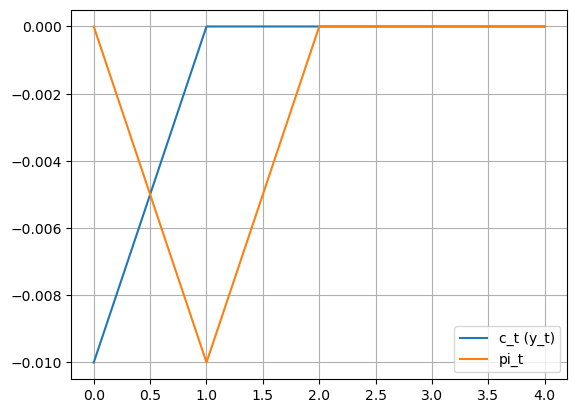

In [42]:


# Example: fixed i=0, expected productivity sequence
T = 5
i_path = np.ones(T)*(1/(beta_hh)-1)   # fixed nominal rate
abar = np.zeros(T)
eps = np.zeros(T)
abar[0] = 0.01

c, pi = euler_path_fixed_wages(i_path, abar, theta=1.0)

import matplotlib.pyplot as plt
plt.plot(c, label='c_t (y_t)')
plt.plot(pi, label='pi_t')
plt.legend(); plt.grid(True); plt.show()


In [43]:
import numpy as np
import itertools

sequence_length = 5
r_choice = np.linspace(0, 0.0125, 6)  # 6 values from 0 to 0.0125 inclusive

# Generate all possible combinations (Cartesian product)
all_combinations = list(itertools.product(r_choice, repeat=sequence_length))

# Convert to NumPy array
big_array = np.array(all_combinations)

print(big_array.shape)  # Should be (6^6, 6) = (46656, 6)

# Assign to r_arrange
r_arrange = big_array
size = r_arrange.shape[0]

(7776, 5)


In [44]:
k=0
T = 10

deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, 10)) 
for r in r_arrange: 
        

    # Example: fixed i=0, expected productivity sequence
    i_path = np.ones(T)*(1/(beta_hh)-1)   # fixed nominal rate
    abar = np.zeros(T)
    eps = np.zeros(T)
    abar[0] = 0.01
    r_arrange_list = np.ones(T) *(1/(beta_hh)-1)
    r_arrange_list[0:sequence_length] = r_arrange[k]

    c, pi = euler_path_fixed_wages(r_arrange_list, abar, theta=1.0)
    deviation_gap[k] = np.sum((c )**2)  + np.sum((pi )**2)
    C_consumption[k, :len(c)] = c.flatten()
    k = k+1

In [45]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([1036])

In [46]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [47]:
r_arrange[argmins_gap]

array([[0.  , 0.01, 0.01, 0.01, 0.01]])

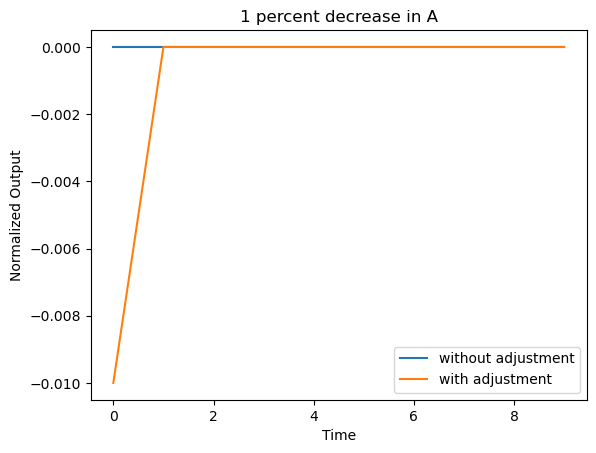

In [48]:
plt.plot( C_consumption[argmins_gap, :19].T, label='without adjustment')
plt.plot( C_consumption[matches, :19].T, label='with adjustment')

plt.legend()
plt.title('1 percent decrease in A')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

In [49]:
import numpy as np
import itertools

sequence_length = 4
r_choice = np.linspace(0, 0.0125, 6)  # 6 values from 0 to 0.0125 inclusive

# Generate all possible combinations (Cartesian product)
all_combinations = list(itertools.product(r_choice, repeat=sequence_length))

# Convert to NumPy array
big_array = np.array(all_combinations)

print(big_array.shape)  # Should be (6^6, 6) = (46656, 6)

# Assign to r_arrange
r_arrange = big_array
size = r_arrange.shape[0]

(1296, 4)


In [50]:
k=0
T=30
deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, 30))
N_array = np.array(N)

# Compute tprod using product of first tau betas
tau_int = tau.astype(int)    
tvals = tau_int.to_numpy()
for r in r_arrange: 
        

    i_path = np.ones(T)*(1/(beta_hh)-1)   # fixed nominal rate
    abar = np.zeros(T)
    eps = np.zeros(T)

    interest_rate_list = np.ones((T,T)) * 0.01
    # Start with all rows = base

    n = len(r_arrange[k])
    r = np.asarray(r_arrange[k], dtype=float)
    fill = 0.01

    arr2d = np.full((n, n), fill, dtype=float)

    # Fill each row with the backward-looking rates
    for i in range(n):
        arr2d[i, :i+1] = r[i::-1]

    # Put into big matrix
    interest_rate_list[0:n, :n] = arr2d

    # Compute beta
    beta = 1.0 / (1.0 + interest_rate_list)


    cumprod_ext = np.ones((30,31))
    cumprod_ext[:,1:] = np.cumprod(beta,axis=1)
    beta_prod = cumprod_ext[:,tvals] 

    tprod_array = np.array((beta_prod * ccccc) * (((tvals + N_array))*np.ones((30,269)) ))
    prod_shock = np.ones((30,269))
    A = generate_pattern_array_with_extra_rows(tau)
    prod_shock[0:15] =A[1:]
    inside = 1/(prod_shock*tprod_array)**(sigma-1)
    A_prod = np.sum( inside,axis = 1)**(1/(sigma-1))

    i_path = np.ones(T)*(1/(beta_hh)-1)  # fixed nominal rate
    i_path[0:sequence_length] = r_arrange[k]  
    abar = np.log(A_prod)  # log productivity sequence

    c, pi = euler_path_fixed_wages(i_path, abar, theta=1.0)
    deviation_gap[k] = np.sum((c )**2)  + np.sum((pi)**2)
    C_consumption[k, :len(c)] = c.flatten() 
    k = k+1

In [51]:
np.shape(tprod_array)

(30, 269)

In [52]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [53]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([1246])

In [54]:
r_arrange[argmins_gap]

array([[0.0125, 0.01  , 0.0075, 0.01  ]])

In [55]:
target = np.array([0.01, 0.01  , 0.0075, 0.01  ])

matches2 = np.all(np.isclose(r_arrange, target), axis=1)

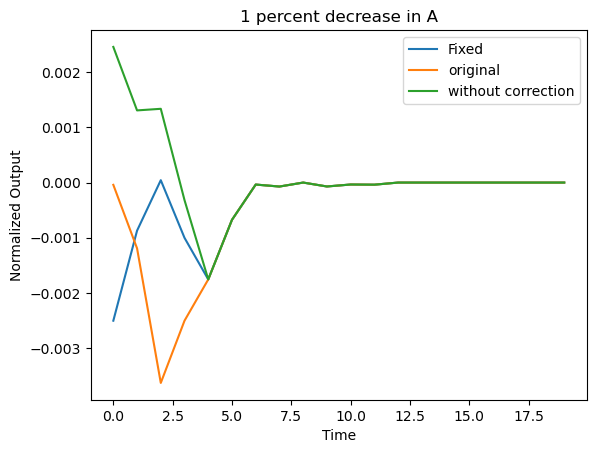

In [56]:
plt.plot( C_consumption[argmins_gap, :20].T, label='Fixed')
plt.plot( C_consumption[matches, :20].T, label='original' )
plt.plot( C_consumption[matches2, :20].T, label='without correction' )

plt.legend()
plt.title('1 percent decrease in A')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

In [57]:
import numpy as np

def find_duplicate_indices_per_row(arr, tol=0.0):
    """
    arr : (R, C) array
    tol : tolerance for considering two values equal (0.0 means exact match)

    Returns:
      list of length R; each item is a list of column indices that are in duplicate groups
    """
    dup_indices = []
    for row in arr:
        if tol > 0:
            # use tolerance
            idxs = []
            for i in range(len(row)):
                for j in range(i+1, len(row)):
                    if abs(row[i] - row[j]) <= tol:
                        idxs.extend([i, j])
            dup_indices.append(sorted(set(idxs)))
        else:
            # exact match
            vals, inv, counts = np.unique(row, return_inverse=True, return_counts=True)
            dups = np.where(counts > 1)[0]            # values that repeat
            cols = np.where(np.isin(inv, dups))[0]    # col indices of those values
            dup_indices.append(cols.tolist())
    return dup_indices

In [58]:
jjjjj=0
T=30
deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, 30))
N_array = np.array(N)

# Compute tprod using product of first tau betas
tau_int = tau.astype(int)    
tvals = tau_int.to_numpy()
for r in r_arrange: 

    interest_rate_list = np.ones((T,T)) * 0.01
    # Start with all rows = base

    n = len(r_arrange[jjjjj])
    r = np.asarray(r_arrange[jjjjj], dtype=float)
    fill = 0.01

    arr2d = np.full((n, n), fill, dtype=float)

    # Fill each row with the backward-looking rates
    for i in range(n):
        arr2d[i, :i+1] = r[i::-1]

    # Put into big matrix
    interest_rate_list[0:n, :n] = arr2d

    # Compute beta
    beta = 1.0 / (1.0 + interest_rate_list)* ccccc

    cumprod_ext = np.ones((T,T+1))
    cumprod_ext[:,1:] = np.cumprod(beta,axis=1)
    tau_list = np.linspace(0, T, T+1)
    time_list_stuff = tau_list*np.ones((T,T+1))
    tprod = (cumprod_ext )[:, :, None] * (time_list_stuff[:, :, None] + np.array(N)[None, None, :])
    tprod_array = np.array(tprod)

    # idx_max will be (30, 269), giving the best column index for each (i, k)
    idx_max = np.argmax(tprod_array, axis=1)  # axis=1 corresponds to the 31 columns

    # Now gather the max values
    max_vals = np.max(tprod, axis=1)    # shape (30, 269)

    tau_best = idx_max


    time_period=np.linspace(0,29,30)*np.ones_like(tau_best).T
    tau_timing= tau_best.T + time_period
    Productivity = np.zeros((len(tau_timing), 30))
    Productivity = max_vals.T
    shocky = 0.99


    duplicates = find_duplicate_indices_per_row(tau_timing)
    for i in range(len(tau_timing)):
        k = 0
        for j in tau_timing[i,tau_timing[i,:]<30]:
            if k in duplicates[i]:
                for kkk in duplicates[i]:
                    if tau_timing[i,kkk] == j:
                        if k == 0:
                            big=shocky* max_vals[k,i] > max_vals[kkk,i]
                            if big == True:
                                Productivity[i,int(j)] = shocky* max_vals[k,i]
                                Productivity[i,int(tau_timing[i,kkk])] = 0
                            else:
                                Productivity[i,int(j)] = 0
                        else:
                            big= max_vals[k,i] > max_vals[kkk,i]
                            if big == True:
                                Productivity[i,int(tau_timing[i,kkk])] = 0
                            else:
                                Productivity[i,int(j)] = 0
            else:
                if k ==0:
                    Productivity[i,int(j)] = shocky* max_vals[k,i]
            k = k+1
    A_prod = 1/np.sum( (Productivity)**(sigma-1),axis = 0)**(1/(sigma-1))
    
    i_path = np.ones(T)*(1/(beta_hh)-1)  # fixed nominal rate
    i_path[0:sequence_length] = r_arrange[jjjjj]  
    abar = np.log(A_prod)  # log productivity sequence

    c, pi = euler_path_fixed_wages(i_path, abar, theta=1.0)
    deviation_gap[jjjjj] = np.sum((c )**2)  + np.sum((pi)**2)
    C_consumption[jjjjj, :len(c)] = c.flatten() 
    jjjjj = jjjjj+1


In [59]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [60]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([1036])

In [61]:
r_arrange[argmins_gap]

array([[0.01, 0.01, 0.01, 0.01]])

In [62]:
target = np.array([0.0125, 0.01  , 0.0075, 0.01  ])

matches2 = np.all(np.isclose(r_arrange, target), axis=1)

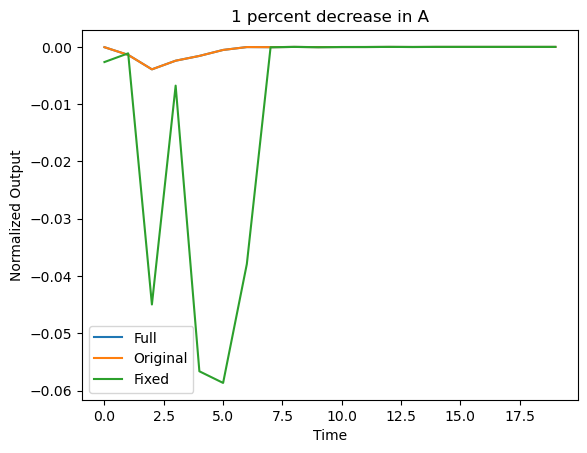

In [63]:
plt.plot( C_consumption[argmins_gap, :20].T, label='Full')
plt.plot( C_consumption[matches, :20].T, label='Original' )
plt.plot( C_consumption[matches2, :20].T, label='Fixed' )

plt.legend()
plt.title('1 percent decrease in A')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()